<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/DZ%203%20Errec_%D0%A4%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_Pro_%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_2_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD_%D1%81_%D0%AE%D0%BB%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import files
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adadelta, Adam


#Загрузка данных

*Разбор данного раздела:* https://youtu.be/Hm41rb1zqQo?t=7582

In [0]:
#Загружаем файлы
files.upload()
!ls #Выводим содержимое корневой папки

Saving cars_new for Python.csv to cars_new for Python.csv
'cars_new for Python.csv'   sample_data


In [0]:
#Считываем csv с помощью pandas
cars = pd.read_csv('cars_new for Python.csv', sep=',')
cars[:5] #Выводим первые 5 машин 

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [0]:
print(cars.values.shape)

(70119, 10)


In [0]:
#Создаём словарь поле - его индекс
def create_dict(s):
  ret = {} #Создаём пустой словарь
  for _id, name in enumerate(s): #Проходим по всем парам - id и название
    ret.update({name: _id}) #Добавляем в словарь
  return ret

#ФУнкция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [0]:
#Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

#Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

#Запоминаем числовые параметры
#И нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [0]:
print(marks_dict)

{'daewoo': 0, 'opel': 1, 'kia': 2, 'nissan': 3, 'toyota': 4, 'mercedes-benz': 5, 'honda': 6, 'ford': 7, 'volkswagen': 8, 'suzuki': 9, 'chevrolet': 10, 'bmw': 11, 'peugeot': 12, 'hyundai': 13, 'chery': 14, 'renault': 15, 'subaru': 16, 'mazda': 17, 'audi': 18, 'mitsubishi': 19, 'skoda': 20}


0 Создаем полную базу данных.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


#Нейронка

*Разбор данного раздела:* https://youtu.be/Hm41rb1zqQo?t=8166

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10119 samples
Epoch 1/20
60000/60000 [==============================] - 310s 5ms/sample - loss: 0.5098 - val_loss: 0.4798
Epoch 2/20
60000/60000 [==============================] - 308s 5ms/sample - loss: 0.3127 - val_loss: 0.3895
Epoch 3/20
60000/60000 [==============================] - 309s 5ms/sample - loss: 0.2583 - val_loss: 0.3462
Epoch 4/20
60000/60000 [==============================] - 307s 5ms/sample - loss: 0.2306 - val_loss: 0.3238
Epoch 5/20
60000/60000 [==============================] - 309s 5ms/sample - loss: 0.2120 - val_loss: 0.3011
Epoch 6/20
60000/60000 [==============================] - 305s 5ms/sample - loss: 0.1980 - val_loss: 0.2874
Epoch 7/20
60000/60000 [==============================] - 307s 5ms/sample - loss: 0.1869 - val_loss: 0.2748
Epoch 8/20
60000/60000 [==============================] - 306s 5ms/sample - loss: 0.1780 - val_loss: 0.2650
Epoch

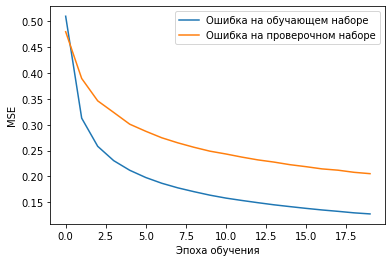

Средняя ошибка:  75725.0
Средняя цена:  530277.0
Процент ошибки: 14.0%


In [0]:
#Создаём сеть
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

1.1 создаем базу данных
, **марки и модели** машин не включаем.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr =  to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [0]:
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10119 samples
Epoch 1/20
60000/60000 [==============================] - 179s 3ms/sample - loss: 0.4923 - val_loss: 0.4638
Epoch 2/20
60000/60000 [==============================] - 178s 3ms/sample - loss: 0.3062 - val_loss: 0.3909
Epoch 3/20
60000/60000 [==============================] - 177s 3ms/sample - loss: 0.2678 - val_loss: 0.3604
Epoch 4/20
60000/60000 [==============================] - 176s 3ms/sample - loss: 0.2471 - val_loss: 0.3412
Epoch 5/20
60000/60000 [==============================] - 178s 3ms/sample - loss: 0.2331 - val_loss: 0.3250
Epoch 6/20
60000/60000 [==============================] - 178s 3ms/sample - loss: 0.2232 - val_loss: 0.3149
Epoch 7/20
60000/60000 [==============================] - 178s 3ms/sample - loss: 0.2153 - val_loss: 0.3051
Epoch 8/20
60000/60000 [==============================] - 176s 3ms/sample - loss: 0.2084 - val_loss: 0.2989
Epoch

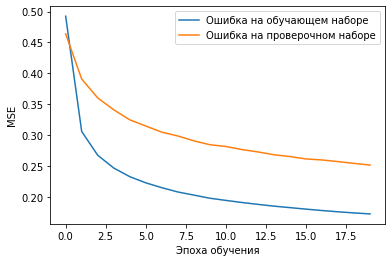

Средняя ошибка:  107160.0
Средняя цена:  530277.0
Процент ошибки: 20.0%


In [0]:
#Создаём сеть
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**1.2** создаем базу данных без учета **модели** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть без "модели"
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
60000/60000 [==============================] - 177s 3ms/sample - loss: 0.4719 - val_loss: 0.4540
Epoch 2/20
60000/60000 [==============================] - 176s 3ms/sample - loss: 0.2935 - val_loss: 0.3758
Epoch 3/20
60000/60000 [==============================] - 177s 3ms/sample - loss: 0.2489 - val_loss: 0.3396
Epoch 4/20
60000/60000 [==============================] - 177s 3ms/sample - loss: 0.2253 - val_loss: 0.3161
Epoch 5/20
60000/60000 [==============================] - 177s 3ms/sample - loss: 0.2096 - val_loss: 0.2997
Epoch 6/20
60000/60000 [==============================] - 175s 3ms/sample - loss: 0.1979 - val_loss: 0.2862
Epoch 7/20
60000/60000 [==============================] - 174s 3ms/sample - loss: 0.1889 - val_loss: 0.2768
Epoch 8/20
60000/60000 [==============================] - 174s 3ms/sample - loss: 0.1816 - val_loss: 0.2675
Epoch 9/20
60000/60000 [==============================] - 174s 3ms/sample - loss: 0.17

**1.3** Создаем базу без учета типа **кузова** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть без "кузова"
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10119 samples
Epoch 1/30
60000/60000 [==============================] - 308s 5ms/sample - loss: 0.5149 - val_loss: 0.4799
Epoch 2/30
 1220/60000 [..............................] - ETA: 4:46 - loss: 0.2559

KeyboardInterrupt: ignored

**1.4** Создаем базу без учета типа **КПП** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
 6800/60000 [==>...........................] - ETA: 4:28 - loss: 0.7763

KeyboardInterrupt: ignored

**1.5** Создаем базу без учета типа **топлива** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
 4700/60000 [=>............................] - ETA: 4:42 - loss: 0.8714

KeyboardInterrupt: ignored

**1.6** Создаем базу без учета типа **обем двигателя** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
 5300/60000 [=>............................] - ETA: 4:43 - loss: 0.8028

KeyboardInterrupt: ignored

**1.7** Создаем базу без учета типа **мощности двигателя** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] 
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни проценt ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
 6220/60000 [==>...........................] - ETA: 4:34 - loss: 1.0294

KeyboardInterrupt: ignored

**1.8** Создаем базу без учета **года выпуска** автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
 6920/60000 [==>...........................] - ETA: 4:32 - loss: 1.0975

KeyboardInterrupt: ignored

**1.9** Создаем базу без учета **пробега**  автомобиля.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
 2060/60000 [>.............................] - ETA: 5:13 - loss: 0.7004

KeyboardInterrupt: ignored

**1.10** Создаем базу без учета **марки** автомобиля.

In [0]:
# создаем базу данных
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**2** Отключаем нормализацию входных данных.

In [0]:
#Задаем числовые параметры без нормализации

years = cars['year']
mileages = cars['mileage']
volumes = cars['volume']
powers = cars['power']


In [0]:
# создаем базу данных
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/20
23280/60000 [==========>...................] - ETA: 3:06 - loss: 313.5793

KeyboardInterrupt: ignored


**ВЫВОД**

**3** Проверяем влияние на ошибку, операции преобразования входных данных "года выпуска автомобиля" в формат +ohe.

In [0]:
#Запоминаем числовые параметры
#И нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        to_ohe(car[3], years(_id)) + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(2500, activation='relu'))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Train on 60000 samples, validate on 10119 samples
Epoch 1/30
60000/60000 [==============================] - 312s 5ms/sample - loss: 0.5507 - val_loss: 0.5121
Epoch 2/30
60000/60000 [==============================] - 312s 5ms/sample - loss: 0.3287 - val_loss: 0.4059
Epoch 3/30
60000/60000 [==============================] - 311s 5ms/sample - loss: 0.2691 - val_loss: 0.3593
Epoch 4/30
35800/60000 [================>.............] - ETA: 2:00 - loss: 0.2505

KeyboardInterrupt: ignored

**ВЫВОД**

**4**`**Архитектура сети НС**`.

In [0]:
x_train = []
y_train = []

#Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  #В y_train добавляем цену
  y_train.append(prices[_id])
  
  #В x_train объединяем все параметры
  #Категорийные параметры добавляем в ваде ohe
  #Числовые параметры добавляем напрямую
  x_tr =  to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  #Добавляем текущую строку в общий z_train
  x_train.append(x_tr)

#Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)
#Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

**4.1** добавляем  слой Dropout в НС.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(2500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.2** добавляем слой Batch Normalization.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.3** меняем активационную функцию elu

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='elu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2500, activation='elu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.4** меняем активационную функцию linear

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='linear', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2500, activation='linear'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.5** меняем активационную функцию sigmoid

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2500, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.6** меняем шаг обучения

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-3
model.compile(optimizer=Adam(lr=0.001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.7** меняем размер батча.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=40,
                    epochs=20, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.8**  меняем число нейронов НС, увеличиваем.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(4500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(3500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.9** меняем число нейронов НС, уменьшаем.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.11** меняем число слоев НС, уменьшаем.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(2500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**

**4.10** меняем число слоев НС, увеличиваем.

In [0]:
#Создаём сеть 
model = Sequential()
model.add(Dense(4500, activation='relu', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(3500, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2500, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

#Указываем прямо шаг обучения - 1е-6
model.compile(optimizer=Adam(lr=0.000001), loss='mse')

#60000 примеров будет в обучающей выборке
n_val = 60000
history = model.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=20,
                    epochs=30, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

#Отображаем графики ошибки обучения на всех эпохах
#Один по обучающей выборке, второй по проверочной
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Предсказываем проверочную выборку
predict = model.predict(x_train[n_val:])
#Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

#Считаем ошибку и модуль ошибки прогнозирования по всем примерам
delta = predict - y_train[n_val:]
abs_delta = abs(delta)

#Считаем среднюю цену, среднюю ошибку и средни процени ошибки
#Выводим на экран
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(y_train[n_val:])/len(y_train[n_val:])
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

**ВЫВОД**